# Setup

In [1]:
import numpy as np
import torch
import torch.autograd as autograd

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

import cyipopt
from cyipopt import Problem
from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

import logging

# Set up logging configuration
logging.basicConfig(filename='optimization_log.txt', 
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
# np.random.seed(12102001)
# torch.manual_seed(12102001)

import matplotlib.pyplot as plt
import matplotx
import mplcyberpunk

matplotx.styles.duftify(matplotx.styles.dracula)
plt.style.use(matplotx.styles.dracula)

torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True,precision=4)

# Parameters
T = 24  # Time horizon
D = 2  # Number of risky assets
r = 0.0275  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.02  # Transaction cost rate
# tau = 0.0  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Include consumption flag
include_consumption = False  # Set to True to include consumption

# Parameters
N = 100  # Number of sample points for the Value function surrogate
k = 90 # number of sample points for the historic returns

# Risky assets
# Drift (mean log-returns)
mu = np.array([0.065, 0.065])  # Assume both assets have the same drift

# Volatilities (standard deviation of log-returns)
sigma = np.array([0.2, 0.2])  # Different volatilities for assets

# Correlation matrix of the log-returns
Sigma = np.array([[1.0, 0.0],   # Correlation of 0.0 between assets
                  [0.0, 1.0]])



# Simulate returns and train gp model for expectation

Epoch 1/100 - Loss: 1.1447200775146484
Epoch 11/100 - Loss: 1.1066890954971313
Epoch 21/100 - Loss: 1.0682106018066406
Epoch 31/100 - Loss: 1.0292702913284302
Epoch 41/100 - Loss: 0.989774763584137
Epoch 51/100 - Loss: 0.9495816826820374
Epoch 61/100 - Loss: 0.9086793065071106
Epoch 71/100 - Loss: 0.867146909236908
Epoch 81/100 - Loss: 0.8250463008880615
Epoch 91/100 - Loss: 0.7824528813362122
Empirical mean of log-returns:  [0.0418 0.0665]
Empirical covariance of log-returns: 
 [[0.0354 0.0044]
 [0.0044 0.0407]]
Empirical mean of returns:  [1.0607 1.0907]
Empirical covariance of returns: 
 [[0.0382 0.0038]
 [0.0038 0.0506]]
Predicted means for two assets: 
 tensor([[0.0287, 0.0534]])
Predicted covariances between assets: 
 tensor([[    1.6891,     0.0004],
        [    0.0004,     0.7126]])


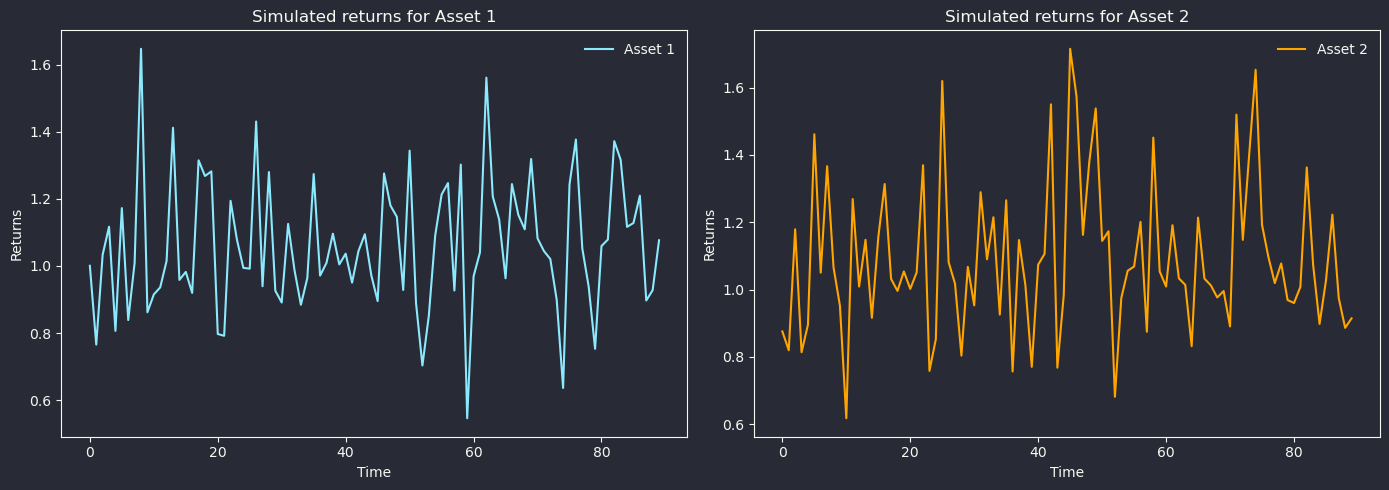

In [2]:

def construct_covariance_matrix(sigma, Sigma):
    """
    Constructs the covariance matrix from standard deviations and correlation matrix.

    Args:
        sigma (np.ndarray): 1D array of standard deviations.
        Sigma (np.ndarray): 2D correlation matrix.

    Returns:
        np.ndarray: Covariance matrix.
    """
    # return np.diag(sigma**(1/2)) @ Sigma @ np.diag(sigma**(1/2))
    return np.diag(sigma) @ Sigma @ np.diag(sigma)

# Generate Simulated Log-Returns (similar to the structure you had)
def simulate_returns(mu, sigma, Sigma, num_data_points=364):
    """
    Simulates log-returns and returns based on the given parameters.

    Args:
        mu (np.ndarray): 1D array of mean log-returns.
        sigma (np.ndarray): 1D array of standard deviations of log-returns.
        Sigma (np.ndarray): 2D correlation matrix of log-returns.
        num_data_points (int): Number of time periods to simulate.

    Returns:
        tuple: Tuple containing:
            - log_returns (np.ndarray): Simulated log-returns.
            - returns (np.ndarray): Simulated returns.
    """
    # Construct covariance matrix
    Sigma_cov = construct_covariance_matrix(sigma, Sigma)
    
    # Ensure the covariance matrix is positive definite
    try:
        L = np.linalg.cholesky(Sigma_cov)
    except np.linalg.LinAlgError:
        # Add a small jitter to the diagonal for numerical stability
        jitter = 1e-6
        Sigma_cov += np.eye(Sigma_cov.shape[0]) * jitter
        L = np.linalg.cholesky(Sigma_cov)
        print(f"Added jitter to covariance matrix for Cholesky decomposition: {jitter}")
    
    # Generate independent standard normal variables
    z = np.random.normal(size=(num_data_points, len(mu)))
    
    # Initialize log-returns array
    log_returns = np.zeros((num_data_points, len(mu)))
    
    for t in range(num_data_points):
        # Generate correlated shocks
        correlated_shocks = L @ z[t]
        # Compute log-returns
        log_returns[t] = mu - 0.5 * sigma**2 + correlated_shocks
    
    # Exponentiate to get returns
    returns = np.exp(log_returns)
    return log_returns, returns
# Define the GP Model using multitask kernels
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # Convert mu and covariance matrix to torch tensors
        # mu_tensor = torch.from_numpy(mu).float()
        # Sigma_cov = construct_covariance_matrix(sigma, Sigma)
        # Sigma_cov_tensor = torch.from_numpy(Sigma_cov).float()
        # print(f"Sigma_cov_tensor: {Sigma_cov_tensor}")
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(),
        # self.mean_module = gpytorch.means.MultitaskMean(
        #     gpytorch.means.ConstantMean(prior=gpytorch.priors.MultivariateNormalPrior(
        #         loc=mu_tensor,
        #         covariance_matrix=Sigma_cov_tensor
        #     )),
            num_tasks=num_tasks
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
            num_tasks=num_tasks, rank=1
        )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Train GP Model on Asset Returns
def train_return_gp_model(train_x, train_y):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1])
    model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=train_y.shape[1])

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Reduced learning rate
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    num_epochs = 100  # Increased iterations
    for i in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {i+1}/{num_epochs} - Loss: {loss.item()}')        

    return model, likelihood

# Predict Returns using the GP Model
def predict_returns(model, likelihood, X_test):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_test))
    return observed_pred.mean, observed_pred.covariance_matrix

log_returns , returns = simulate_returns(mu, sigma, Sigma, num_data_points=k)


# X_train = torch.linspace(0, k-1, k).unsqueeze(-1)  # Input: time or other features
scaler_time = StandardScaler()
scaler_time = MaxAbsScaler()
X_train_time = torch.linspace(0, k-1, k).unsqueeze(-1).numpy()
X_train_time_scaled = scaler_time.fit_transform(X_train_time)
X_train = torch.from_numpy(X_train_time_scaled).float()

# y_train = torch.from_numpy(np.random.multivariate_normal(mu, Sigma, num_data_points)).float()  # Returns
# y_train = torch.from_numpy(returns).float()  # Returns
y_train = torch.from_numpy(log_returns).float()  # Returns

returnsmodel , returnlikelihood = train_return_gp_model(X_train, y_train)

X_test = torch.linspace(k+1, k+1, 1).unsqueeze(-1)  # New time steps for prediction
predicted_returns, covariance_matrix = predict_returns(returnsmodel, returnlikelihood, X_test)

# Verify the mean and covariance of the log-returns
print("Empirical mean of log-returns: ", np.mean(log_returns, axis=0))
print("Empirical covariance of log-returns: \n", np.cov(log_returns.T))

# Verify the mean and covariance of the log-normal returns (this won't match the log-returns directly)
print("Empirical mean of returns: ", np.mean(returns, axis=0))
print("Empirical covariance of returns: \n", np.cov(returns.T))


# Output mean and covariance
print("Predicted means for two assets: \n", predicted_returns)
print("Predicted covariances between assets: \n", covariance_matrix)
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# Plot for Asset 1
axs[0].plot(returns[:, 0], label='Asset 1')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Returns')
axs[0].set_title('Simulated returns for Asset 1')
axs[0].legend()

# Plot for Asset 2 with a different color
axs[1].plot(returns[:, 1], label='Asset 2', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Returns')
axs[1].set_title('Simulated returns for Asset 2')
axs[1].legend()

plt.tight_layout()

In [5]:
for t in reversed(range(22)):
    print(t)
    # Define varying time steps for prediction
    Return_time = torch.tensor([[t]], dtype=torch.float32).numpy()
    
    # Scale the new time step using the previously fitted scaler
    Return_time_scaled = scaler_time.transform(Return_time)
    
    # Convert the scaled time step back to a PyTorch tensor
    Return_time_tensor = torch.from_numpy(Return_time_scaled).float()
    
    # Make predictions using the GP model
    tilde_Rt, tilde_Covar  = predict_returns(returnsmodel, returnlikelihood, Return_time_tensor)
    
    # Exponentiate log-returns to get returns
    predicted_returns = np.exp(tilde_Rt.numpy())
    print(predicted_returns)

21
[[1.0333 1.0584]]
20
[[1.0327 1.0577]]
19
[[1.032 1.057]]
18
[[1.0313 1.0563]]
17
[[1.0305 1.0556]]
16
[[1.0297 1.055 ]]
15
[[1.0288 1.0543]]
14
[[1.0278 1.0536]]
13
[[1.0268 1.053 ]]
12
[[1.0257 1.0523]]
11
[[1.0246 1.0517]]
10
[[1.0235 1.051 ]]
9
[[1.0223 1.0504]]
8
[[1.0211 1.0498]]
7
[[1.0199 1.0492]]
6
[[1.0187 1.0487]]
5
[[1.0175 1.0481]]
4
[[1.0163 1.0476]]
3
[[1.0151 1.047 ]]
2
[[1.014  1.0465]]
1
[[1.0129 1.046 ]]
0
[[1.0118 1.0455]]


# Dynamic programming

In [124]:
torch.set_printoptions(sci_mode=False, precision=4)
torch.set_printoptions(sci_mode=False, precision=4)
# Define the GPR model with ARD
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
            jitter=1e-6  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-6)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 200
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return model, likelihood

def utility(var, gamma):
    var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility

def safe_utility(var, gamma):
    return utility(var, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Ensure xt, delta_plus, delta_minus are [1, D]
    # bt = 1.0 - torch.sum(xt + delta_minus - delta_plus) - torch.sum(tau * delta_plus) - torch.sum(tau * delta_minus)
    bt = 1.0 - torch.sum(xt - delta_minus + delta_plus) - torch.sum(tau * delta_plus) - torch.sum(tau * delta_minus)
    bt = torch.clamp(bt, min=0.0, max=1.0)
    return bt  # Scalar

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    transaction_costs = torch.sum(tau * delta_plus - tau * delta_minus)
    #equation 7
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt, dim=1) #- transaction_costs
    # pi_t1 = torch.clamp(pi_t1, min=1e-8)  # [1]
    
    # equation 9
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1.unsqueeze(-1)  # [1, D]
    
    # Wealth between periods doesent matter
    Wt = torch.sensor(1.0, dtype=torch.float32)

    # equation 8
    Wt1 = Wt * pi_t1
    return pi_t1, xt1

def V_terminal(xT):
    terminal_utility = utility(1.0 - tau * torch.sum(xT, dim=-1), gamma)
    return terminal_utility  # Shape: [1]

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, convex_hull=None, t=None):
    """
    Computes the value function vt using the Bellman equation.

    Args:
        vt_next_in: Value function inside NTR (function or GP model)
        vt_next_out: Value function outside NTR (function or GP model)
        xt: Current state, tensor of shape [1, D]
        delta_plus: Purchase adjustments, tensor of shape [1, D]
        delta_minus: Sale adjustments, tensor of shape [1, D]
        beta: Discount factor
        gamma: Risk aversion coefficient
        tau: Transaction cost rate
        Rf: Risk-free rate
        convex_hull: Convex hull of the NTR (optional)
        t: Current time step

    Returns:
        vt: Value function at time t, tensor of shape [1]
    """    
    # Ensure xt, delta_plus, delta_minus have shape [1, D]
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"
        
    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Asset returns
    Rt = 1.0 + torch.tensor(mu, dtype=torch.float32, device=xt.device).unsqueeze(0)  # Shape: [1, D]
    Return_time = torch.linspace(k+1, k+1, 1).unsqueeze(-1)  # New time steps for prediction
    tilde_Rt, tilde_Covar  = predict_returns(returnsmodel, returnlikelihood, Return_time)
    # Removed .expand(xt.size(0), -1) to prevent duplication

    # Next period's wealth and state
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, tilde_Rt, bt, Rf)

    # Check for non-finite pi_t1
    if not torch.isfinite(pi_t1).all():
        logging.warning(f"Non-finite pi_t1 detected with values: {pi_t1}")
        return torch.full((1,), float('inf'), device=xt.device)

    # Determine if next state is inside NTR
    in_ntr = is_in_ntr(xt1, convex_hull, delta_plus, delta_minus, t)

    # Evaluate the next period's value function
    xt1_input = xt1.detach()
    vt_next_vals = torch.zeros(1, dtype=torch.float32, device=xt.device)

    # Ensure models are in evaluation mode
    if isinstance(vt_next_in, gpytorch.models.ExactGP):
        vt_next_in.eval()
    if isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_out.eval()

    with torch.no_grad():
        if isinstance(vt_next_in, gpytorch.models.ExactGP):
            vt_next_val_in = vt_next_in(xt1_input).mean # [1]
        else:
            vt_next_val_in = V_terminal(xt1_input)  # [1]

        if isinstance(vt_next_out, gpytorch.models.ExactGP):
            vt_next_val_out = vt_next_out(xt1_input).mean # [1]
        else:
            vt_next_val_out = V_terminal(xt1_input)  # [1]

        # Assign values based on NTR
        vt_next_vals[in_ntr] = vt_next_val_in[in_ntr].float()
        vt_next_vals[~in_ntr] = vt_next_val_out[~in_ntr].float()

    # Check if current period is the terminal period (T)
    if t == T:
        vt_next_vals = V_terminal(xt1_input).squeeze(-1)  # [1]

    # Check for non-finite vt_next_vals
    if not torch.isfinite(vt_next_vals).all():
        logging.warning(f"Non-finite vt_next_vals detected with values: {vt_next_vals}")
        return torch.full((1,), float('inf'), device=xt.device)
    
    # Compute current value function
    vt = beta * ((pi_t1 ** (1.0 - gamma)) * vt_next_vals)

    # Check for non-finite vt
    if not torch.isfinite(vt).all():
        logging.warning(f"Non-finite vt detected with value: {vt}")
        return torch.full((1,), float('inf'), device=xt.device)

    return vt

def sample_state_points(D):
    """
    Samples points at the vertices and midpoints of the state space simplex.

    Args:
        D: Dimension of the state space (number of assets)

    Returns:
        valid_points: Tensor of shape [num_points, D]
    """
    from itertools import product
    # Generate all combinations of 0 and 1 for D dimensions
    points = list(product([0.0, 1.0], repeat=D))
    # Add the midpoint
    midpoint = [0.5] * D
    points.append(tuple(midpoint))
    # Filter out points where the sum exceeds 1
    valid_points = [point for point in points if sum(point) <= 1.0]
    return torch.tensor(valid_points, dtype=torch.float32)  # Shape: [num_points, D]

# def sample_state_points_simplex(D, N):
#     """
#     Samples N random points from the D-dimensional simplex.

#     Args:
#         D: Dimension of the state space
#         N: Number of points to sample

#     Returns:
#         points: Tensor of shape [N, D]
#     """
#     # Generate random points in the simplex
#     dirichlet_dist = torch.distributions.Dirichlet(torch.ones(D))
#     points = dirichlet_dist.sample((N,))  # Shape: [N, D]
#     return points  # Shape: [N, D]

def sample_state_points_simplex(D, N, max_attempts=50):
    """
    Samples N random points from the D-dimensional simplex where the sum of components is <= 1.

    Args:
        D (int): Dimension of the state space (number of assets).
        N (int): Number of points to sample.
        max_attempts (int, optional): Maximum number of sampling attempts to achieve N points. Defaults to 10.

    Returns:
        torch.Tensor: Tensor of shape [N, D] containing the sampled points.
    """
    sampled_points = []
    attempts = 0
    total_required = N

    while len(sampled_points) < N and attempts < max_attempts:
        # Sample more points than needed to increase chances of acceptance
        sample_size = (total_required - len(sampled_points)) * 2
        points = torch.rand(sample_size, D)
        # Filter points where the sum of components is <= 1
        valid_points = points[torch.sum(points, dim=1) <= 1.0]
        sampled_points.extend(valid_points.tolist())
        attempts += 1

    if len(sampled_points) < N:
        raise ValueError(f"Could not sample {N} points with sum <= 1 after {max_attempts} attempts.")

    # Convert to tensor and select the first N points
    sampled_points = torch.tensor(sampled_points[:N], dtype=torch.float32)
    return sampled_points  # Shape: [N, D]

def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=1e-3, t=None):
    """
    Determines whether each point in x is inside the NTR.

    Args:
        x: State points, tensor of shape [1, D]
        convex_hull: ConvexHull object representing the NTR
        delta_plus: Purchase adjustments, tensor of shape [1, D] (optional)
        delta_minus: Sale adjustments, tensor of shape [1, D] (optional)
        epsilon_ntr: Tolerance for the NTR
        t: Current time step (for debugging)

    Returns:
        in_ntr: Boolean tensor of shape [1], True if inside NTR
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    # Ensure x is float32
    x = x.float()

    # Extract convex hull equations and perform tensor operations
    equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float32)
    equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float32)

    inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [1, num_constraints]
    in_convex_hull = torch.all(inequalities <= epsilon_ntr, dim=1)  # Shape: [1]

    if delta_plus is not None and delta_minus is not None:
        delta = delta_plus - delta_minus
        delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [1]
        return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [1]

    return in_convex_hull  # Shape: [1]

def MertonPoint(mu, Sigma, r, gamma):
    # Compute the Merton portfolio weights
    Lambda = np.diag(np.sqrt(np.diag(Sigma)))
    Lambda_Sigma_Lambda = np.dot(Lambda, np.dot(Sigma, Lambda))
    Lambda_Sigma_Lambda_inv = np.linalg.inv(Lambda_Sigma_Lambda)
    mu_r = mu - r
    pi = np.dot(Lambda_Sigma_Lambda_inv, mu_r / gamma)
    return pi

class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        tau,
        Rf,
        mu,
        Sigma,
        convex_hull=None,
        include_consumption=False,
        ntr_mid_point=None
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.convex_hull = convex_hull
        self.include_consumption = include_consumption
        self.ntr_mid_point = ntr_mid_point

        if not isinstance(xt, torch.Tensor):
            print(f"XT IS NOT A TENSOR, xt type: {type(xt)}")

        # Number of variables: delta_plus, delta_minus
        self.n = 2 * D

        # Number of constraints: D constraints from xt + delta >= 0, and 3 scalar constraints
        self.m = D + 3

        # Variable bounds
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # Constraint bounds
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.

        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            obj_value: Scalar value of the objective function (negative of vt)
        """

        idx = 0

        # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[idx : idx+self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[idx + self.D : idx + 2 * self.D].unsqueeze(0)  # Shape: [1, D]
        
        # Compute the value function
        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,            # Shape: [1, D]
            delta_plus,        # Shape: [1, D]
            delta_minus,       # Shape: [1, D]
            self.beta,
            self.gamma,
            self.tau,
            self.Rf,
            self.convex_hull,
            self.t              # Pass current time step
        ) # vt: [1]
        
        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")      
        
        # Ensure vt is a scalar
        vt_scalar = vt.squeeze(0).item()  # Convert tensor to scalar

        return -vt_scalar  # IPOPT minimizes, so negate to maximize

    def gradient(self, params):
        """
        Gradient of the objective function.

        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            grads: Numpy array of shape [2*D], gradient of the objective function
        """

        # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)

        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        
        # Compute the value function
        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,            # Shape: [1, D]
            delta_plus,        # Shape: [1, D]
            delta_minus,       # Shape: [1, D]
            self.beta,
            self.gamma,
            self.tau,
            self.Rf,
            self.convex_hull,
            self.t              # Pass current time step
        ) # vt: [1]
        
        # Compute gradients
        vt.backward()
        
        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # IPOPT minimizes, so negate gradients

    def compute_constraints(self, params_tensor):
        """
        Compute the constraints for the optimization problem.

        Args:
            params_tensor: Torch tensor of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            constraints_tensor: Torch tensor of shape [m], representing the constraints
        """
        assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
        assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"
        
        # Extract delta_plus and delta_minus from the parameter vector
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        delta = delta_plus - delta_minus  # Shape: [1, D]
        xt = self.xt  # Shape: [1, D]

        # Constraint 1: xt + delta >= 0 (element-wise for each asset)
        constraints_xt_delta = (xt + delta).squeeze(0)  # Shape: [D]

        # Constraint 2: bond holdings bt >= 0
        bt = normalized_bond_holdings(
            xt,             # [1, D]
            delta_plus,     # [1, D]
            delta_minus,    # [1, D]
            self.tau
        )  # Scalar

        # Constraint 3: sum(xt + delta) <= 1
        sum_allocations = torch.sum(xt + delta)  # Scalar
        constraint_sum_leq_1 = 1.0 - sum_allocations  # Scalar

        # Constraint 4: sum(xt + delta) >= 0 (redundant but included)
        constraint_sum_geq_0 = sum_allocations  # Scalar

        # Concatenate all constraints into a single tensor
        constraints_tensor = torch.cat([
            constraints_xt_delta,                 # Shape: [D] (asset allocation constraints)
            bt.unsqueeze(0),                     # Shape: [1] (bond holdings constraint)
            constraint_sum_leq_1.unsqueeze(0),   # Shape: [1] (sum allocation <= 1)
            constraint_sum_geq_0.unsqueeze(0)    # Shape: [1] (sum allocation >= 0)
        ])  # Shape: [D + 3]

        # Ensure the tensor does not have NaNs or infinities
        constraints_tensor = torch.nan_to_num(constraints_tensor, nan=1e11, posinf=1e11, neginf=-1e11)
        return constraints_tensor

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.

        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            constraints_array: Numpy array of shape [m], representing the constraints
        """
        try:
            # Convert NumPy array to PyTorch tensor
            params_tensor = torch.tensor(params, dtype=torch.float32, device='cpu')
            assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
            assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"
            
            # Compute constraints using PyTorch tensors
            constraints_tensor = self.compute_constraints(params_tensor)
            
            # Convert constraints back to NumPy array for IPOPT
            constraints_array = constraints_tensor.detach().cpu().numpy()
            return constraints_array
        except Exception as e:
            logging.error(f"Error in constraints method: {e}", exc_info=True)
            # Return large positive values to indicate infeasibility
            return np.full(self.m, 1e9)   

    # def jacobian(self, params):
    #     """
    #     Computes the Jacobian of the constraints.

    #     Args:
    #         params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

    #     Returns:
    #         jacobian_flat: Numpy array of shape [m*n], representing the flattened Jacobian matrix
    #     """
    #     try:
    #         # Convert parameters to a tensor with gradient tracking
    #         params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
    #         assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
    #         assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"
            
    #         # Compute all constraints as tensor
    #         constraints_combined = self.compute_constraints(params_tensor)
            
    #         # Compute the Jacobian using torch.autograd.functional.jacobian
    #         def constraint_func(x):
    #             return self.compute_constraints(x)
            
    #         jacobian_tensor = torch.autograd.functional.jacobian(
    #             constraint_func, params_tensor
    #         )  # Shape: [m, n]
            
    #         # Ensure the Jacobian has shape (m, n)
    #         if jacobian_tensor.dim() == 2 and jacobian_tensor.shape == (self.m, self.n):
    #             jacobian_flat = jacobian_tensor.view(-1).detach().cpu().numpy()
    #             return jacobian_flat        
    #         else:
    #             raise ValueError(f"Unexpected Jacobian shape: {jacobian_tensor.shape}")
    #     except Exception as e:
    #         logging.error(f"Error in jacobian method: {e}", exc_info=True)
    #         # Return a flat array of zeros or another fallback as appropriate
    #         return np.zeros(self.m * self.n)
        
    def jacobian(self, params):
        """
        Computes the Jacobian matrix of the constraints.
        
        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]
        
        Returns:
            jacobian_flat: Numpy array of shape [m*n], representing the flattened Jacobian matrix
        """
        D = self.D
        tau = self.tau
        # Initialize Jacobian matrix with zeros
        jac = np.zeros((self.m, self.n))
        
        # Asset Allocation Constraints
        for d in range(D):
            # Derivatives with respect to delta_plus
            jac[d, d] = 1.0
            # Derivatives with respect to delta_minus
            jac[d, D + d] = -1.0
        
        # Bond Holdings Constraint (g_D)
        for d in range(D):
            jac[D, d] = -1.0 - tau  # delta_plus derivatives
            jac[D, D + d] = 1.0 - tau  # delta_minus derivatives
        
        # Sum Allocation Constraints (g_{D+1} and g_{D+2})
        for d in range(D):
            # Constraint g_{D+1}: 1 - sum(x + delta) >= 0
            jac[D + 1, d] = -1.0
            jac[D + 1, D + d] = 1.0
            
            # Constraint g_{D+2}: sum(x + delta) >= 0
            jac[D + 2, d] = 1.0
            jac[D + 2, D + d] = -1.0
        
        # Flatten the Jacobian in column-major order
        jacobian_flat = jac.flatten(order='C')
        return jacobian_flat
    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
    convex_hull=None, ntr_mid_point=None, include_consumption=False, num_starts=10, drop_tolerance=0.2):
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    max_failed_attempts = int(num_starts * (1.0 - drop_tolerance))

    logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        # print(f"adding batch dimension to xt {xt}")
        xt = xt.unsqueeze(0)  # Shape: [1, D]
        # print(f"xt : {xt}")

    def generate_feasible_initial_guess(xt, D, tau, include_consumption=False, max_attempts=1000):
        attempts = 0
        while attempts < max_attempts:        
            if torch.allclose(xt, torch.tensor([[0.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.rand(D, dtype=torch.float32) * 0.125  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float32)       # Shape: [D]
                delta_plus = delta_plus.unsqueeze(0)  # Now shape: [1, D]
                delta_minus = delta_minus.unsqueeze(0)  # Now shape: [1, D]

            elif torch.allclose(xt, torch.tensor([[1.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.09], dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                delta_minus = torch.tensor([0.175, 0.0], dtype=torch.float32).unsqueeze(0) # Shape: [1, D]

            elif torch.allclose(xt, torch.tensor([[0.0, 1.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.09, 0.0], dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                delta_minus = torch.tensor([0.0, 0.175], dtype=torch.float32).unsqueeze(0) # Shape: [1, D]
            elif torch.allclose(xt, torch.tensor([[0.5, 0.5]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.0], dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                delta_minus = torch.tensor([0.075, 0.075], dtype=torch.float32).unsqueeze(0) # Shape: [1, D]

            else:
                # Ensure xt is [1, D]
                delta_plus = (torch.rand(D, dtype=torch.float32) * (1 - xt)*0.9).unsqueeze(0)  # Shape: [1, D]
                delta_minus = (torch.rand(D, dtype=torch.float32) * xt*0.9).unsqueeze(0)     # Shape: [1, D]

            delta_plus = torch.clamp(delta_plus, 0, 1)
            delta_minus = torch.clamp(delta_minus, 0, 1)
            delta = delta_plus - delta_minus

            transaction_costs = tau * torch.sum(delta_plus + delta_minus)
            bt = 1.0 - torch.sum(xt + delta) - transaction_costs
            if bt < 0:
                attempts += 1
                continue

            x_plus_delta = xt + delta  # [1, D] + [1, D] -> [1, D]
            if torch.any(x_plus_delta < 0) or (1.0 - torch.sum(x_plus_delta) < 0):
                attempts += 1
                continue

            # Ensure that the initial guess is returned as a 1D tensor of length 2*D
            initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()  # Shape: [2 * D]
            assert initial_guess.shape[0] == 2 * D, f"Initial guess has incorrect length: {initial_guess.shape[0]}"
            return initial_guess  # Return a 1D tensor

        raise ValueError("Failed to generate a feasible initial guess after maximum attempts")
    # Loop through multiple starting points
    for start_idx in range(num_starts):
        try:
            initial_guess = generate_feasible_initial_guess(xt, D, tau, include_consumption=False)
            logging.debug(f"Start {start_idx}: Initial guess generated.")
        except ValueError as e:
            logging.warning(f"Start {start_idx}: {e}")
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                tau,
                Rf,
                mu,
                Sigma=Sigma,
                convex_hull=convex_hull,
                ntr_mid_point=ntr_mid_point,
                include_consumption=include_consumption,
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-6)
            prob.add_option("max_iter", 500)
            prob.add_option("print_level", 2)
            prob.add_option("honor_original_bounds", "yes")
            prob.add_option("mu_strategy", "adaptive")        # Adaptive step size strategy
            prob.add_option("mu_oracle", "quality-function")  # Control step quality            
            prob.add_option("constr_viol_tol", 1e-6)          # Constraint violation tolerance
            prob.add_option("bound_push", 0.015)          # Constraint violation tolerance
            prob.add_option("hessian_approximation", 'limited-memory') # Special Ipopt Feauture, Quasi-Newton Approximation of Second Derivatives
            # prob.add_option("derivative_test", "first-order")  # First-order derivative verification
            # prob.add_option("derivative_test_tol", 1e-6)        # Derivative test tolerance
            # Convert initial_guess to NumPy array
            initial_guess_np = initial_guess.cpu().numpy()
            assert len(initial_guess_np) == 2 * D, f"Initial guess length {len(initial_guess_np)} != {2 * D}"
            solution, info = prob.solve(initial_guess_np)

            # Check if the solution is valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            if len(solution) != 2 * D:
                print(f"wrong length, solution is: {solution}")
                logging.warning(f"Start {start_idx}: Unexpected solution length: {len(solution)}. Expected: {2 * D}")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_info = info
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        logging.error(f"No optimizer solution found for point {xt}!")
        return None, None, None, None, None

    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]  # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        delta_opt = delta_plus_opt - delta_minus_opt  # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt  # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor, tau
        ).item()

        # logging.info(f"Best solution found: Delta+: {delta_plus_opt}, Delta-: {delta_minus_opt}, Delta: {delta_opt}, Omega: {omega_i_t}, bt: {bt}")
        return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        logging.error(f"Error processing best solution: {e}", exc_info=True)
        return None, None, None, None, None

def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, tau, Rf, mu, Sigma):
    """
    Approximates the Non-Trading Region (NTR) at time t.

    Args:
        vt_next_in: Value function inside NTR at time t+1
        vt_next_out: Value function outside NTR at time t+1
        D: Number of assets
        t: Current time
        T: Terminal time
        beta, gamma, tau, Rf, mu, Sigma: Model parameters

    Returns:
        tilde_omega_t: NTR vertices, numpy array of shape [num_points, D]
        convex_hull: ConvexHull object representing the NTR
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
        if delta_plus is not None:
            # Reshape delta to [1, D] for consistency
            delta = torch.tensor(delta, dtype=torch.float32).unsqueeze(0)  # [1, D]
            tilde_omega_i_t = (tilde_x_i_t + delta)  # Shape: [1, D]
            tilde_omega_t.append(tilde_omega_i_t.squeeze(0).detach().numpy())  # [D]
    
    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def bayesian_active_learning(model, likelihood, state_space, num_new_points=10):
    """
    Applies Bayesian Active Learning to select new points with the highest uncertainty.

    Args:
        model: Trained GP model
        likelihood: Likelihood associated with the GP model
        state_space: Tensor of state points, shape [num_points, D]
        num_new_points: Number of new points to select

    Returns:
        new_samples: Tensor of selected state points, shape [num_new_points, D]
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = model(state_space)
        variance = pred_dist.variance  # Shape: [num_points]

    # Ensure state_space and variance are tensors
    state_space = torch.tensor(state_space) if not isinstance(state_space, torch.Tensor) else state_space
    variance = torch.tensor(variance) if not isinstance(variance, torch.Tensor) else variance

    # Check shapes
    assert state_space.dim() == 2, f"Expected state_space to be 2D, got {state_space.dim()}D"
    assert variance.dim() == 1, f"Expected variance to be 1D, got {variance.dim()}D"
    assert state_space.size(0) == variance.size(0), "Mismatch in number of points between state_space and variance"

    # Adjust num_new_points if it is greater than the length of variance
    num_new_points = min(num_new_points, len(variance))

    # Get the top indices based on variance
    _, top_var_indices = torch.topk(variance, num_new_points)

    # Select new samples from state_space using the top indices
    new_samples = state_space[top_var_indices]  # Shape: [num_new_points, D]

    return new_samples

# Initialize value function V
V = [[None, None] for _ in range(T + 1)]

# Set terminal value function
V[T][0] = V_terminal  # For inside NTR
V[T][1] = V_terminal  # For outside NTR

NTRs = [None for _ in range(T)]  # Store NTRs for each period

for t in reversed(range(T)):

    print(f"Time step {t}")
    # Step 2a: Approximate NTR
    print("Step 2a: Approximate NTR")
    tilde_omega_t, convex_hull = approximate_ntr(V[t + 1][0], V[t + 1][1], D, t, T, beta, gamma, tau, Rf, mu, Sigma)
    NTRs[t] = convex_hull

    # Step 2b: Sample state points
    print("Step 2b: Sample state points")
    X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
    data_in = []
    data_out = []

    for i in range(len(X_t)):
        x_i_t = X_t[i]  # Shape: [D]
        # Step 2c: Solve optimization problem
        logging.info(f"Step 2c: Solve optimization problem for point {x_i_t}")
        delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
            D, x_i_t, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
            convex_hull=NTRs[t]
        )
        if delta_plus is None:
            logging.warning(f"Step 2c: Optimization failed for point {x_i_t}. Skipping.")
            continue  # Skip if optimization failed
        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True,precision=4)
        print(f"Best solution found. Point {x_i_t},  Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta}, Omega: {omega_i_t}, bt: {np.round(b_t,4)}")

        logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta}, Omega: {omega_i_t}, bt: {b_t}")

        # Compute value using Bellman equation
        # Reshape x_i_t to [1, D]
        # x_i_t_tensor = torch.tensor(x_i_t, dtype=torch.float32).unsqueeze(0)  # [1, D]
        x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
        delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
        v_i_t = bellman_equation(
            V[t + 1][0],
            V[t + 1][1],
            x_i_t_tensor, 
            delta_plus_tensor, 
            delta_minus_tensor, 
            beta, gamma, tau, Rf, convex_hull=NTRs[t],
            t=t
        )  # Shape: [1]

        # Determine if the point is inside the NTR and append to the respective data set
        in_ntr = is_in_ntr(x_i_t_tensor, convex_hull, delta_plus_tensor, delta_minus_tensor, t=t)  # [1]
        if in_ntr.item():
            data_in.append((x_i_t, v_i_t.item()))
        else:
            data_out.append((x_i_t, v_i_t.item()))

    # Step 2e: Train GPR models for inside and outside NTR
    print("Step 2e: Train GPR models for inside and outside NTR")
    if data_in:
        train_x_in = torch.tensor(np.array([d[0] for d in data_in]), dtype=torch.float32)  # [num_in, D]
        print(f"train_x_in done ")
        train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
        print(f"train_y_in done ")
        model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
        V[t][0] = model_in
        print(f"train gp model_in done ")
        # Apply Bayesian Active Learning to add new high-uncertainty points
        new_samples_in = bayesian_active_learning(model_in, likelihood_in, train_x_in, num_new_points=int(0.1*N))  # Use train_x_in for uncertainty
        for sample in new_samples_in:
            # sample is [D], reshape to [1, D]
            sample_tensor = sample.unsqueeze(0)  # [1, D]
            delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma, convex_hull=NTRs[t]
            )
            if delta_plus is None:
                continue
            # Reshape for bellman_equation
            delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            v_i_t_new = bellman_equation(V[t + 1][0], V[t + 1][1], sample_tensor, 
                                        delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, convex_hull=NTRs[t],
                                        t=t)
            data_in.append((sample.detach().cpu().numpy(), v_i_t_new.item()))
        print(f"new_samples_in done")
    
    # Problem: Right now everything is being appended to data_out, so data_in is empty
    if data_out:
        train_x_out = torch.tensor(np.array([d[0] for d in data_out]), dtype=torch.float32)  # [num_out, D]
        train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
        model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
        V[t][1] = model_out

        # Apply Bayesian Active Learning to add new high-uncertainty points
        new_samples_out = bayesian_active_learning(model_out, likelihood_out, train_x_out, num_new_points=int(0.1*N))  # Use train_x_out for uncertainty
        for sample in new_samples_out:
            # sample is [D], reshape to [1, D]
            sample_tensor = sample.unsqueeze(0)  # [1, D]
            delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma, convex_hull=NTRs[t]
            )
            if delta_plus is None:
                continue
            # Reshape for bellman_equation
            delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            v_i_t_new = bellman_equation(V[t + 1][0], V[t + 1][1], sample_tensor, 
                                        delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, convex_hull=NTRs[t],
                                        t=t)
            data_out.append((sample.detach().cpu().numpy(), v_i_t_new.item()))

    # Retrain GPR models with the new data
    if data_in:
        train_x_in = torch.tensor(np.array([d[0] for d in data_in]), dtype=torch.float32)  # [num_in, D]
        train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
        model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
        V[t][0] = model_in

    if data_out:
        train_x_out = torch.tensor(np.array([d[0] for d in data_out]), dtype=torch.float32)  # [num_out, D]
        train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
        model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
        V[t][1] = model_out

Time step 23
Step 2a: Approximate NTR

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Optimization failed for start 0: module 'torch' has no attribute 'sensor'
Optimization failed for start 1: module 'torch' has no attribute 'sensor'
Optimization failed for start 2: module 'torch' has no attribute 'sensor'
Optimization failed for start 3: module 'torch' has no attribute 'sensor'
Optimization failed for start 4: module 'torch' has no attribute 'sensor'
Optimization failed for start 5: module 'torch' has no attribute 'sensor'
Optimization failed for start 6: module 'torch' has no attribute 'sensor'
Optimization failed for start 7: module 'torch' has no at

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

hull = convex_hull

if hull is not None:
    vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
    D = vertices.shape[1]  # Dimension of the state space
    plt.figure()

    if D == 2:
        # 2D plot
        for simplex in hull.simplices:
            plt.plot(vertices[simplex, 0], vertices[simplex, 1], 'k-')
        plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightgray', alpha=0.5)
        plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
        plt.title(f'NTR at time {t}')
        plt.xlabel('State dimension 1')
        plt.ylabel('State dimension 2')
        plt.xlim(0, 1)
        plt.ylim(0, 1)

    
    plt.show()

else:
    print(f"Not enough vertices to form an NTR at time {t}")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure()

        if D == 2:
            # 2D plot
            for simplex in hull.simplices:
                plt.plot(vertices[simplex, 0], vertices[simplex, 1], 'k-')
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightgray', alpha=0.5)
            plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
            plt.title(f'NTR at time {t}')
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
        
        elif D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
            ax.add_collection3d(Poly3DCollection(vertices[hull.simplices], facecolors='lightgray', edgecolors='k', alpha=0.4))
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
        
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTRs, 5)